In [537]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sklearn.datasets
from tqdm import tqdm

In [561]:
class nn_model:
    def __init__(self, layers_dims):
        self.layers_dims = layers_dims
        self.L = len(self.layers_dims)-1 # sub 1 for input layer
        # variable of Z and A, we don't use the index 0
        self.A = [None for i in range(self.L+1)]
        self.Z = [None for i in range(self.L+1)]
        self.dA = [None for i in range(self.L+1)]
        self.dZ = [None for i in range(self.L+1)]
        # parameter of W and b, we don't use the index 0
        self.W = [None for i in range(self.L+1)]
        self.b = [None for i in range(self.L+1)]
        self.dW = [None for i in range(self.L+1)]
        self.db = [None for i in range(self.L+1)]
        # parameter for Adam 
        self.vdW = [None for i in range(self.L+1)]
        self.vdb = [None for i in range(self.L+1)]
        self.sdW = [None for i in range(self.L+1)]
        self.sdb = [None for i in range(self.L+1)]
        # the number of examples
        self.m = 0
        # the cost between y_hat and y
        self.cost = 0
        # the list store the J value
        self.J = []
        # random initial
        self.initial_params()
        
    def sigmoid(self, Z):
        A = 1 / (1+np.exp(-Z))
        return A 
    
    def sigmoid_prime(self, Z):
        s = self.sigmoid(Z)
        dZ = s*(1-s)
        return dZ
    
    def relu(self, Z):
        A = np.maximum(0,Z)
        return A
    
    def relu_prime(self, Z):
        (rows, cols) = Z.shape
        dZ = np.array([[1.0 if Z[i, j] > 0 else 0.0 for j in range(cols)] for i in range(rows)])
        return dZ
        
    def set_data(self, X, Y):
        self.X = X
        self.Y = Y
        self.A[0] = X
        self.m = X.shape[1]
        # X.shape[0] is the n_x
        assert(X.shape[0] == self.W[1].shape[1])
        # Y.shape[0] is the n_y
        assert(Y.shape[0] == self.W[-1].shape[0])
    
    def initial_params(self):
        for i in range(1, self.L+1): # iter from 1 ~ L layer
            self.W[i] = np.random.randn(self.layers_dims[i], self.layers_dims[i-1])*np.sqrt(2/self.layers_dims[i-1])
            self.b[i] = np.zeros((self.layers_dims[i], 1))
            # take a assert for certain the dimension
            assert(self.W[i].shape == (self.layers_dims[i], self.layers_dims[i-1]))
            assert(self.b[i].shape == (self.layers_dims[i], 1))
            # adam params
            self.vdW[i] = np.zeros(self.W[i].shape)
            self.vdb[i] = np.zeros(self.b[i].shape)
            self.sdW[i] = np.zeros(self.W[i].shape)
            self.sdb[i] = np.zeros(self.b[i].shape)
        
    def linear_activation_forward(self, A_prev, W, b, activation):
        """
        Arguments:
        A_prev: the A(activated) value of previous layer 
        W: the parameter 'W' of current layer
        b: the parameter 'b' of current layer
    
        activation: the activation function used in neuron

        Returns:
        A = the activated value computed by A_prev and the parameters
        Z = the value after linear function
        """
        Z = np.dot(W, A_prev) + b # the linear part 
        if(activation == 'sigmoid'):
            A = self.sigmoid(Z)
        elif(activation == 'relu'):
            A = self.relu(Z)
            
        assert(Z.shape == (W.shape[0], A.shape[1])) # (n_h, m)
        assert(A.shape == Z.shape)
        return Z, A
    
    def forward(self):
        # iter from 1 ~ L-1 layer
        for i in range(1, self.L):
            A_prev = self.A[i-1]
            W = self.W[i]
            b = self.b[i]
            self.Z[i], self.A[i] = self.linear_activation_forward(A_prev, W, b, 'relu')
            
        # the last L layer, sigmoid for binary classifier
        A_prev = self.A[self.L-1]
        W = self.W[self.L]
        b = self.b[self.L]
        self.Z[self.L], self.A[self.L] = self.linear_activation_forward(A_prev, W, b, 'sigmoid')
        
    def compute_cost(self):
        # beacause here is a binary classifier so the output n_y == 1
        cost = (-1./ self.m)*np.sum(self.Y*np.log(self.A[-1]) + (1-self.Y)*np.log(1-self.A[-1]), axis=1)
        self.cost = np.squeeze(cost)
        self.J.append(self.cost)
        assert(self.cost.shape == ())
            
    def linear_activation_backward(self, dZ_next, Z, W_next, activation):
        dA = np.dot(W_next.T, dZ_next)
        if activation == 'sigmoid':
            dZ = dA*self.sigmoid_prime(Z)
        elif activation == 'relu':
            dZ = dA*self.relu_prime(Z)
        return dA, dZ
        
    def backward(self):    
        #dA[-1] = dJ/da
        #self.dA[-1] = -(np.divide(self.Y, self.A[-1])-np.divide(1-self.Y, 1-self.A[-1]))
        # the last dZ is often computed by hand
        self.dZ[-1] = self.A[-1] - self.Y
        self.dW[-1] = (1./self.m) * np.dot(self.dZ[-1], self.A[-2].T)
        self.db[-1] = (1./self.m) * np.sum(self.dZ[-1], axis=1, keepdims=True)
        
        # iter from L-1 to 1 layer
        for i in range(self.L-1, 0, -1):
            dZ_next = self.dZ[i+1]
            Z = self.Z[i]
            W_next = self.W[i+1]
            self.dA[i], self.dZ[i] = self.linear_activation_backward(dZ_next, Z, W_next, 'relu')
            # dw, db
            self.dW[i] = (1./self.m) * np.dot(self.dZ[i], self.A[i-1].T)
            self.db[i] = (1./self.m) * np.sum(self.dZ[i], axis=1, keepdims=True)
            assert(self.dW[i].shape == self.W[i].shape)
            assert(self.db[i].shape == self.b[i].shape)
            
    def update_params(self, lr):
        for i in range(1, self.L+1): # iter from 1 to L
            self.W[i] -= lr*self.dW[i]
            self.b[i] -= lr*self.db[i]
            
    def update_params_adam(self, lr = 0.01, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
        for i in range(1, self.L+1): # iter from 1 to L
            # update adam params
            self.vdW[i] = beta1*self.vdW[i] + (1-beta1)*self.dW[i]
            self.vdb[i] = beta1*self.vdb[i] + (1-beta1)*self.db[i]
            vdW_corr = self.vdW[i] / (1 - pow(beta1, i))
            vdb_corr = self.vdb[i] / (1 - pow(beta1, i))
            self.sdW[i] = beta2*self.sdW[i] + (1-beta2)*np.square(self.dW[i])
            self.sdb[i] = beta2*self.sdb[i] + (1-beta2)*np.square(self.db[i])   
            sdW_corr = self.sdW[i] / (1 - pow(beta2, i))
            sdb_corr = self.sdb[i] / (1 - pow(beta2, i))
            # updaate grads
            self.W[i] -= lr*(vdW_corr / (np.sqrt(sdW_corr) + epsilon))
            self.b[i] -= lr*(vdb_corr / (np.sqrt(sdb_corr) + epsilon))
        
    def run(self, epoch=100, lr=0.01, adam=True, prt=False):
        for e in range(epoch):
            nn.forward()
            nn.compute_cost()
            nn.backward()
            if(adam):
                nn.update_params_adam(lr)
            else:
                nn.update_params(lr)
            if(prt):
                print(self.cost)
            
    def predict(self, test_X, test_Y):
        self.set_data(test_X, test_Y)
        self.forward()
        last_layer = (self.A[-1] > 0.5).astype('int')
        rst = last_layer == test_Y
        rst.astype('int')
        accuracy = np.sum(rst) / test_Y.shape[1]
        return accuracy

## Gradient Checking

In [562]:
def matrix_to_vector(nn):
    params = np.array([])
    for i in range(1, nn.L+1):
        params = np.append(params, nn.W[i])
        params = np.append(params, nn.b[i])
    params = params.reshape(-1, 1)
    return params

def set_by_vector(nn, params):
    start = 0
    end = 0
    for i in range(1, nn.L+1):
        start = end
        end += nn.W[i].shape[0]*nn.W[i].shape[1]
        nn.W[i] = params[start: end].reshape(nn.W[i].shape)
        start = end
        end += nn.b[i].shape[0]*nn.b[i].shape[1]
        nn.b[i] = params[start: end].reshape(nn.b[i].shape)

In [563]:
def grads_check(nn):
    # initial var
    epsilon = 1e-7
    grad = np.array([])
    # matrix to vector, and store the initial params for gradapprox
    params = matrix_to_vector(nn)
    # grad
    nn.run(epoch=1)
    for i in range(1, nn.L+1):
        grad = np.append(grad, nn.dW[i])
        grad = np.append(grad, nn.db[i])
    grad = grad.reshape(-1, 1)
    # gradapprox
    set_by_vector(nn, params)
    params_num = params.shape[0]
    J_plus = np.zeros((params_num, 1))
    J_minus = np.zeros((params_num, 1))
    gradapprox = np.zeros((params_num, 1))
    for i in range(params_num):
        # J_plus 
        theta_plus = np.copy(params)
        theta_plus[i] += epsilon
        set_by_vector(nn, theta_plus)
        nn.forward()
        nn.compute_cost()
        J_plus[i] = nn.cost
        # J_minus
        theta_minus = np.copy(params)
        theta_minus[i] -= epsilon
        set_by_vector(nn, theta_minus)
        nn.forward()
        nn.compute_cost()
        J_minus[i] = nn.cost
        # gradapprox
        gradapprox[i] = (J_plus[i] - J_minus[i]) / (2*epsilon)
    # diff
    numerator = np.linalg.norm(grad - gradapprox)                                   
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)
    difference = numerator / denominator 
    print('diff: ', difference)

In [564]:
x = np.random.randn(2, 3)
y = np.random.randn(1, 3) > 0.5
nn = nn_model([x.shape[0], 3, 1])
nn.set_data(x, y)
grads_check(nn)

diff:  1.89773981754e-09


## Toy Dataset

In [565]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

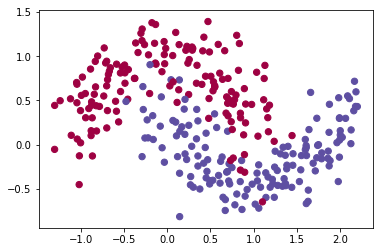

In [566]:
train_X, train_Y = load_dataset()

In [567]:
nn = nn_model([train_X.shape[0], 100, 1]) # the first dimension is the n_x of input 
nn.set_data(train_X, train_Y)
nn.run(epoch=100, lr=0.05, prt=True)

0.755899866727794
0.425725393884891
0.3636421880525122
0.38978755652067143
0.40978753816660696
0.41840419655659583
0.405628233654189
0.38427103974248183
0.36000534981554233
0.33576327738195444
0.3209383144017867
0.309857000175434
0.30362238476962294
0.29311981153446826
0.28552655080559014
0.2767681671566326
0.26916973108096665
0.2600115221116291
0.2524399139144136
0.2433539900335204
0.23350224223930674
0.22450666285813944
0.21607519959215035
0.20960511446268643
0.20379942878097432
0.19671927237495243
0.18812382534567634
0.17970207076790373
0.17415587554261694
0.17038989877463395
0.16673073971099292
0.1623264647586069
0.1577063258625825
0.15349062467503596
0.15073749349366522
0.14869158992978707
0.14611968460994923
0.14353681604367916
0.1416709299918179
0.1405457183450161
0.13968537360998642
0.13844911755294717
0.13701057748141068
0.13585130498336093
0.13511340342142802
0.13440956575268748
0.1334585799240635
0.13256432554895237
0.1320772314063015
0.13180685414079987
0.1314527558581834
0

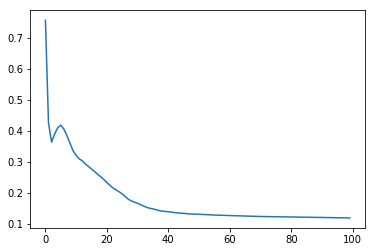

In [568]:
plt.plot(nn.J)

In [569]:
nn.predict(train_X, train_Y)

0.94333333333333336